In [2]:
%reload_ext autoreload
%autoreload 2
import os
from torchsummary import summary
import torchvision
from torchvision import datasets,transforms
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler


In [29]:
# from custom.mnist_net import FreeConvNetwork
from custom.celeba_AlexNet import ConvNet 

# Testing & summarizeing the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ConvNet().to(device)

summary(model, (3, 218, 178))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 108, 88]          23,296
              ReLU-2          [-1, 64, 108, 88]               0
         MaxPool2d-3           [-1, 64, 53, 43]               0
            Conv2d-4          [-1, 192, 27, 22]         307,392
              ReLU-5          [-1, 192, 27, 22]               0
         MaxPool2d-6          [-1, 192, 13, 10]               0
            Conv2d-7          [-1, 384, 13, 10]         663,936
              ReLU-8          [-1, 384, 13, 10]               0
            Conv2d-9          [-1, 256, 13, 10]         884,992
             ReLU-10          [-1, 256, 13, 10]               0
           Conv2d-11          [-1, 256, 13, 10]         590,080
             ReLU-12          [-1, 256, 13, 10]               0
        MaxPool2d-13            [-1, 256, 6, 4]               0
          Dropout-14            [-

In [ ]:
# make a test and training set - CelebA
transform = transforms.Compose(
    [transforms.ToTensor(),
     ]
)
dataset = datasets.ImageFolder("./Data/img_align_celeba/class_data/", transform=transform)

#list all the labels in assigned to the dataset by the ImageFolder method
labels = [label for _, label in dataset]

#make a train/test split from based on the labels using StratifiedShuffleSplit to make sure all labels are evenly represented
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
train_indices, test_indices = next(splitter.split(dataset, labels))

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

#define the dataset loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4)

#report split sizes
print("Training set size: {}".format(len(train_dataset)))
print("Testing set size: {}".format(len(test_dataset)))

# transforms.Normalize([0.5092611312866211, 0.4260057508945465, 0.3815517723560333], 
#                           [0.27129703760147095, 0.24954678118228912, 0.24475571513175964])

In [ ]:
#caluclate the mean and standard deviation of the image dataset for image normalization 
means = 0
std = 0

for images, _ in train_loader:
    
    batch_samples  = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    means += images.mean(2).sum(0)
    std += images.std(2).sum(0)

means /= len(train_loader.dataset)
std /= len(train_loader.dataset)

print("Means: ", means.tolist())
print("STD: ", std.tolist())
print(images.max())


Training set size: 60000
Testing set size: 10000
Labels:  [4 6 5 3]


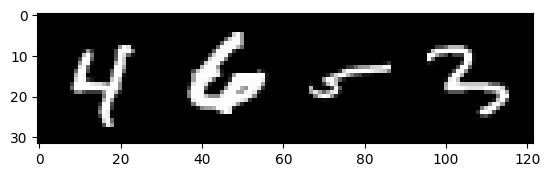

In [32]:
#minst data set
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = datasets.MNIST("./data", train = True, download=True, transform=transform)
test_dataset = datasets.MNIST("./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

#report split sizes
print("Training set size: {}".format(len(train_dataset)))
print("Testing set size: {}".format(len(test_dataset)))

#visualize training data & corresponding labels
dataiter = iter(train_loader)
images, labels = next(dataiter)

print("Labels: ",labels.numpy()[0:4])

images = images[:4,:,:,:]
img_grid = torchvision.utils.make_grid(images)
img_grid = img_grid.permute(1,2,0)

plt.imshow(img_grid)
plt.show()

In [5]:
#Places365 dataset (scene recognition)
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.Places365("E:\Data/Places365/", "train-standard", small=True, download=True, transform=transform)
test_dataset = datasets.Places365("E:\Data/Places365/", "val", small=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5)

#report split sizes
print("Training set size: {}".format(len(train_dataset)))
print("Testing set size: {}".format(len(test_dataset)))

# check if everything is in order
for img in train_loader:
    data, labels = img[0], img[1]
    print(labels)
    print(train_dataset.classes[labels[0]])
    
    x = data[0,:,:,:]
    x = x.permute(1,2,0)
    plt.imshow(x)
    plt.show()
    break

100%|██████████| 67498496/67498496 [04:38<00:00, 242303.56it/s]


Extracting E:\Data/Places365/filelist_places365-standard.tar to E:\Data/Places365/


  3%|▎         | 707067904/26103685120 [59:48<35:48:22, 197021.53it/s]


KeyboardInterrupt: 

Using downloaded and verified file: E:\Data\celeba\img_align_celeba.zip
Using downloaded and verified file: E:\Data\celeba\list_attr_celeba.txt
Using downloaded and verified file: E:\Data\celeba\identity_CelebA.txt
Using downloaded and verified file: E:\Data\celeba\list_bbox_celeba.txt
Using downloaded and verified file: E:\Data\celeba\list_landmarks_align_celeba.txt
Using downloaded and verified file: E:\Data\celeba\list_eval_partition.txt
Training set size: 163265
Testing set size: 19667
Validation set size: 19667
Label tensor(10164)


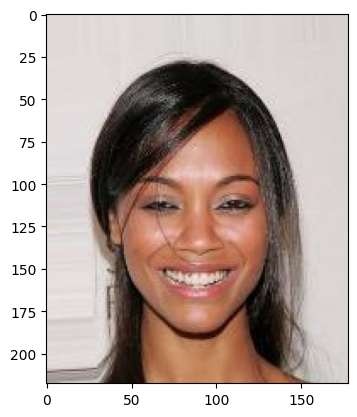

In [3]:
#CelebA Pytorch data set
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.CelebA("E:\Data", "all",target_type="identity", download=True, transform=transform) # load the whole datset


# split identity indicies for face recognition 80% of each class training 10% each for validation and testing
tind_list, vind_list, ttind_list = [], [], []
for ind in range(len(torch.unique(dataset.identity))):
    inds, _ = torch.where(dataset.identity == ind + 1) # get all indices where identity matches the specific label
    train_size = int(len(inds) * 0.8)
    val_size = int((len(inds) -  train_size)/2)
    test_size = int((len(inds) - train_size)/2)
    if sum((train_size, val_size, test_size)) != len(inds):
        train_size += len(inds) - sum((train_size, val_size, test_size))

    # check if the individual classes are split nicely
    # print(train_size, val_size, test_size, sum([train_size, val_size, test_size]))
    # print(len(inds))

    tind, vind, ttind = torch.split(inds, [train_size, val_size, test_size]) # split class indices based on train/val/test split
    tind_list.append(tind)
    vind_list.append(vind)
    ttind_list.append(ttind)
    
# conv lists to tensors
tind_list = torch.cat(tind_list)
vind_list = torch.cat(vind_list)
ttind_list = torch.cat(ttind_list)

# create train/val/test sets
train_dataset = torch.utils.data.Subset(dataset, tind_list)
val_dataset = torch.utils.data.Subset(dataset, vind_list[torch.randperm(len(vind_list))])
test_dataset = torch.utils.data.Subset(dataset, ttind_list[torch.randperm(len(ttind_list))])

#verify that all classes in val data are present in train data
# print(torch.where(torch.isin(torch.unique(dataset.identity[vind_list]), dataset.identity[tind_list]))[0].shape[0] == 
#       len(torch.unique(dataset.identity[vind_list])))
# create loaders
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = 5, shuffle=True, num_workers = 7, pin_memory=True) 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= 5, num_workers=7, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= 5, num_workers=7, pin_memory=True)

#report split sizes
print("Training set size: {}".format(len(train_dataset)))
print("Testing set size: {}".format(len(test_dataset)))
print("Validation set size: {}".format(len(val_dataset)))

# verify images
# verify images
data, label = next(iter(test_loader))
print("Label", label[0])

plt.imshow(data[0,:,:,:].permute(1,2,0))
plt.show()

In [60]:
import pandas as pd

pd.read_csv("./Data/celeba/identity_CelebA.txt", sep=" ", engine="python", header=None).iloc[:,1].unique().max()

10177

In [12]:
model = ConvNet()
state_dict = torch.load("./Snellius_model/4_model_CELEBA_10E_accTest/model_20230728_111348_0")
model.load_state_dict(state_dict)
model.to(device)
summary(model, (3,218,178))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 71, 58]             436
            Conv2d-2           [-1, 16, 23, 19]           1,040
            Conv2d-3            [-1, 32, 11, 9]           4,640
           Flatten-4                 [-1, 3168]               0
            Linear-5                [-1, 10178]      32,254,082
Total params: 32,260,198
Trainable params: 32,260,198
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.44
Forward/backward pass size (MB): 0.31
Params size (MB): 123.06
Estimated Total Size (MB): 123.81
----------------------------------------------------------------


In [95]:
############
# Validation (unseen data)
############

dataset_choice = "celeba"
loss_fn = nn.CrossEntropyLoss()

if not dataset_choice == "mnist":
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        model.train(False)
        for i, data in enumerate(test_loader):
            vdata, vlabels = data
            vdata, vlabels = vdata.to(device), vlabels.to(device)
            
            voutput = model(vdata)

            vloss = loss_fn(voutput, vlabels)
            
            # validation accuracy unseen data
            _, vpred = torch.max(voutput.data,1)
            # print(vlabels)
            # print("   ", vpred)
            vcorrect += (vpred == vlabels).sum()
            vtotal += vlabels.size(0)
            print(vcorrect)
            # print(vcorrect, vtotal)
            

        vacc = vcorrect / vtotal * 100
        print(vcorrect)
        
print("Validation Accuracy on unseen data is {}%".format(vacc))

tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
t

KeyboardInterrupt: 

In [52]:
#moving model to GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = FreeConvNetwork().to(device)

#defining the loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)#), weight_decay=0.1) #weight decay = regularization to keep weights small
loss_fn = nn.CrossEntropyLoss()
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.0001,total_iters=100)

In [53]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(tqdm(train_loader)):

        # Every data instance is an input + label pair
        inputs, labels = data
        
        # moving the training data batch by batch to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # [a,b,c,d,f,e,g] = model(inputs) #debugging for NAN output
        
        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Adjust the Learning rate
        # scheduler.step()
        
        
        # Gather data and report
        running_loss += loss.item()
        
        if i % 1000 == 999:
            # print(optimizer.param_groups[0]["lr"]) #check learning rate scheduler
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [54]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

# print(list(model.children()))
print(model)
EPOCHS = 1

best_vloss = 1_000_000.

if not os.path.isdir("./model"):
    os.makedirs("./model")

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    # model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata
         
        # moving the test data batch by batch to the GPU
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        
        # validating the model
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss.detach().item() # wihtout .detach I get an out of memory error on GPU


    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

ConvNet(
  (sequential_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(6, 6), stride=(3, 3))
    (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(3, 3))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=6336, out_features=10177, bias=True)
  )
)
EPOCH 1:


  3%|▎         | 1003/32554 [00:59<29:09, 18.04it/s]

  batch 1000 loss: 9.212442759513856


  6%|▌         | 2003/32554 [01:55<28:10, 18.07it/s]

  batch 2000 loss: 9.15884213924408


  9%|▉         | 3003/32554 [02:51<26:55, 18.29it/s]

  batch 3000 loss: 9.113991176605225


 12%|█▏        | 4003/32554 [03:47<26:38, 17.87it/s]

  batch 4000 loss: 9.08493805885315


 15%|█▌        | 5003/32554 [04:42<25:28, 18.02it/s]

  batch 5000 loss: 9.051382409095764


 16%|█▋        | 5367/32554 [05:02<25:34, 17.71it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [84]:
#correct vs total classifications 
correct = 0
total = 0

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load the model
# model = FreeConvNetwork()
# model.load_state_dict(torch.load("./model/model_20230530_115318_4"))
# model.to(device)
#print(model.eval())

#predict the test labels
with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader)):
        input, labels = data[0], data[1]
        input, labels = input.to(device), labels.to(device)

        outputs = model(input)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print("Validation Accuracy of the network: %f%%" % (100 * correct/total)) 

100%|██████████| 7300/7300 [04:07<00:00, 29.49it/s]

Validation Accuracy of the network: 4.679452%


In [85]:
# predict the train set
num_c = 0
num_t = 0
stop = len(test_loader)
with torch.no_grad():
    for i, (dfjk) in tqdm(enumerate(train_loader), total=len(test_loader)):
        if i == stop:
            break
        x,y = dfjk[0], dfjk[1]
        x = x.to(device)
        y = y.to(device)
        
        scores = model(x)

        _,pred = scores.max(1)
        num_c += (pred == y).sum().item()
        num_t += pred.size(0)

acc = (num_c / num_t) * 100
print("Training Accuracy of the model: %f%%" %acc)


100%|██████████| 7300/7300 [06:18<00:00, 19.30it/s]

Training Accuracy of the model: 4.958904%


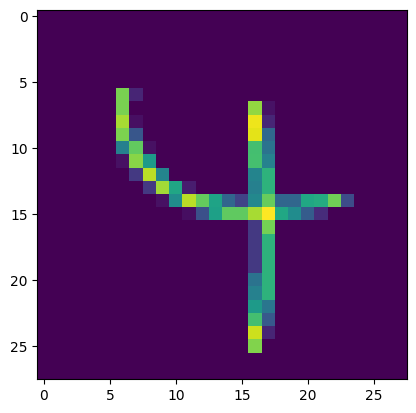

In [20]:
#visualize validation first validation sitmulus

input_image = next(iter(train_loader))[0]
plt.imshow(input_image[0,:,:,:].permute(1,2,0))
plt.show()



In [3]:
9999 % 10000


9999

LocallyConnected2d()
torch.Size([16, 16, 13, 13])


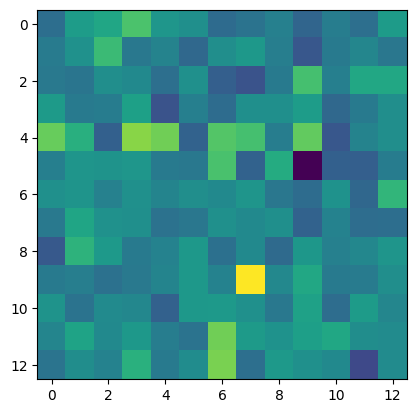

In [25]:
model_children = next(iter(model.children()))
fm= model_children(input_image.to(device)) #[0] with different network
print(fm.size())
fm = fm[0]
plt.imshow(fm[0,:,:].cpu().detach())
plt.show()

In [31]:
# visualize layers of conv network with only one output_channel
model_children = next(iter(model.children()))

list_feature_maps = []
list_feature_maps_relu = []
for layer in range(len(list(model.children()))):
    print(layer)
    if str(type(model_children[layer])) == "<class 'custom.LocallyConnected2d.LocallyConnected2d'>":
        if layer == 0:  
            l_input = input_image.to(device)
        else: 
            l_input = list_feature_maps_relu[-1]
        feature_map = model_children[layer](l_input)
        list_feature_maps.append(feature_map)
        feature_map_ReLU = model_children[layer+1](feature_map)
        list_feature_maps_relu.append(feature_map_ReLU)
        

numb_maps = len(list_feature_maps)
dim = math.ceil(math.sqrt(numb_maps))

fig, axs = plt.subplots(dim, dim, figsize=(14,14))
map_n = 0
for filt_x in range(dim):
    for filt_y in range(dim):
        try:
            feature_map = list_feature_maps[map_n]
            feature_map = feature_map[0,:,:,:]

            axs[filt_x, filt_y].imshow(feature_map[0,:,:].cpu().detach())
            axs[filt_x, filt_y].axis("off")
            map_n += 1
        except:
            IndexError
            axs[filt_x, filt_y].axis("off")
            pass
plt.show()


0


TypeError: 'LocallyConnected2d' object is not subscriptable

In [89]:
next(iter(model.children()))[1]

LocallyConnected2d()

In [22]:
# visualize the first layer in a network with multiple out_channels
import math
import matplotlib.pyplot as plt

input_image = next(iter(test_loader))[0]
feature_map = next(iter(model.children()))[0](input_image.to(device))

feature_map = feature_map[0,:,:,:]
numb_filter = feature_map.size()[0]
dim = math.ceil(math.sqrt(numb_filter))

fig, axs = plt.subplots(dim, dim, figsize=(14,14))
filt_n = 0

for filt_x in range(dim):
    for filt_y in range(dim):
        
        try:
            axs[filt_x, filt_y].imshow(feature_map[filt_n,:,:].cpu().detach())
            axs[filt_x, filt_y].axis("off")
            filt_n += 1
        except:
            IndexError
            axs[filt_x, filt_y].axis("off")
            pass
plt.show()

TypeError: 'LocallyConnected2d' object is not subscriptable

In [45]:
import torchvision
import numpy as np
import torch.nn as nn
import custom
import matplotlib.pyplot as plt

#plot the weights 

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    _,n,c,w,h,_ = tensor.shape
    tensor = tensor[0,:,:,:,:,0]

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    fig = plt.figure(figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    return fig

def visualize_layers(model):
    figs = []
    _model = model.module if type(model) == nn.DataParallel else model
    for name, module in _model.named_modules():
        #print(module)
        if not isinstance(module, nn.Sequential):
            if type(module) == custom.LocallyConnected2d.LocallyConnected2d or type(module) == nn.Conv2d:
                filter = module.weight.cpu().data.clone()
                #filter = filter[0,0,:,:,:,:]
            else:
                continue
            
            fig = visTensor(filter, ch=0, allkernels=True)
            figs.append(fig)
            plt.axis('off')
            plt.title(f'Layer: {name}')
            plt.ioff()

    return figs

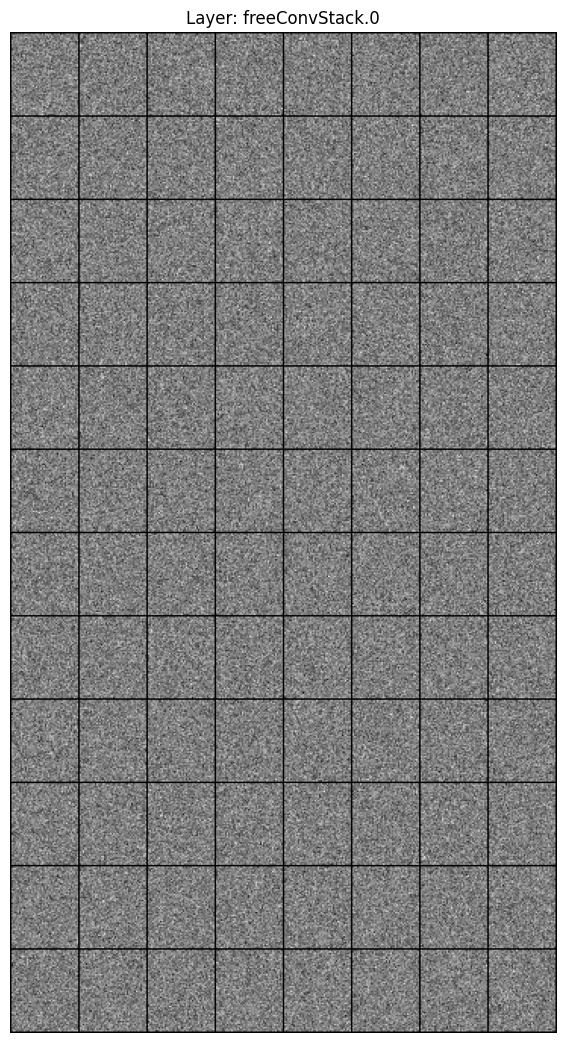

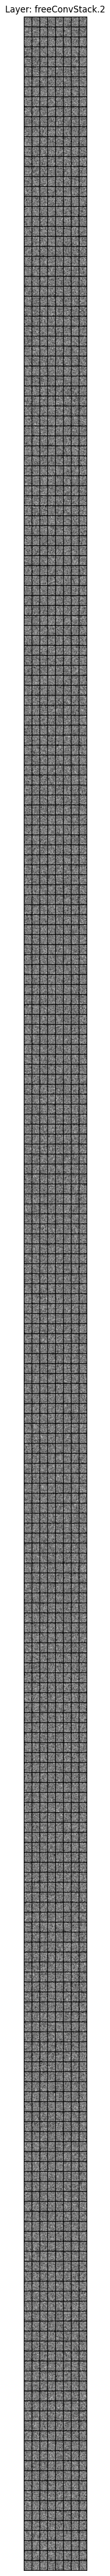

In [57]:

from custom.model import FreeConvNetwork
model = FreeConvNetwork()



fig = visualize_layers(model)

plt.show(fig)